In [39]:
# Import the Relevant Libraries
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the relevant files
train_file = '../../Data/NCBItrainset_corpus.txt'
dev_file = '../../Data/NCBIdevelopset_corpus.txt'
model_name = '../../Models/LSTM_Attention_NER_model.pth'

In [40]:
# Reading the dataset file
def read_dataset(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()
    return lines

def parse_dataset(lines):
    paragraphs = []
    paragraph = []

    for line in lines:
        line = line.strip()
        if line:
            paragraph.append(line)
        else:
            if paragraph:
                paragraphs.append(paragraph)
                paragraph = []

    if paragraph:
        paragraphs.append(paragraph)

    return paragraphs

In [41]:
# Parsing the different paragraphs and annotations
def parse_paragraph(paragraph):
    sentences = []
    annotations = []
    sentence = []

    for line in paragraph:
        if re.match(r'^\d+\|\w\|', line):
            sentence.extend(line.split('|')[2].split())

        elif re.match(r'^\d+\t\d+\t\d+\t', line):
            start, end = int(line.split("\t")[1]), int(line.split("\t")[2])
            annotations.append((start, end, line.split("\t")[3], line.split("\t")[4]))

    if sentence:
        sentences.append(sentence)
    return sentences, annotations

In [42]:
# Data Labelling
def tag_annotations(sentences, annotations):
    tagged_sentences = []
    char_count = 0

    for sentence in sentences:
        tags = ['O'] * len(sentence)    # Initialize all tags at "O"
        word_starts = []
        word_ends = []
        char_pos = 0

        for word in sentence:
            word_starts.append(char_pos)
            char_pos += len(word)
            word_ends.append(char_pos)
            char_pos += 1               # WhiteSpace Character

        '''
        Based on the character limits, the annotations are assigned
        A custom IO tagging scheme is used
        Labels are assigned on the basis of disease label in annotations
        '''

        for start, end, disease_info, label in annotations:
            for i, (word_start, word_end) in enumerate(zip(word_starts, word_ends)):
                if word_start >= start and word_end <= end:
                    tags[i] = 'I-' + label
                elif word_start < start < word_end or word_start < end < word_end:
                    tags[i] = 'I-' + label

        tagged_sentences.append((sentence, tags))

    return tagged_sentences

In [43]:
# Parsing the dataset file
lines = read_dataset(train_file)
paragraphs = parse_dataset(lines)

all_sentences = []
all_tags = []

for paragraph in paragraphs:
    sentences, annotations = parse_paragraph(paragraph)
    tagged_sentences = tag_annotations(sentences, annotations)
    for sentence, tags in tagged_sentences:
        all_sentences.append(sentence)
        all_tags.append(tags)

In [44]:
# Parsing the development dataset file
dev_lines = read_dataset(dev_file)
dev_paragraphs = parse_dataset(dev_lines)

dev_sentences = []
dev_tags = []

for paragraph in dev_paragraphs:
    sentences, annotations = parse_paragraph(paragraph)
    tagged_sentences = tag_annotations(sentences, annotations)
    for sentence, tags in tagged_sentences:
        dev_sentences.append(sentence)
        dev_tags.append(tags)

In [45]:
# Define Dataset class
class LSTM_Attention_NERDataset(Dataset):
    def __init__(self, sentences, tags, word_encoder, tag_encoder, unknown_token='<UNK>'):
        self.sentences = sentences
        self.tags = tags
        self.word_encoder = word_encoder
        self.tag_encoder = tag_encoder
        self.unknown_token = unknown_token

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        tags = self.tags[idx]

        sentence_encoded = [self.word_encoder.get(word, self.word_encoder[self.unknown_token]) for word in sentence]
        tags_encoded = self.tag_encoder.transform(tags)

        return torch.tensor(sentence_encoded), torch.tensor(tags_encoded, dtype=torch.long)

In [46]:
# Prepare data
all_words = [word for sentence in all_sentences for word in sentence]
all_tags_flat = [tag for tags in all_tags for tag in tags]

word_encoder = {word: idx for idx, word in enumerate(set(all_words))}
unknown_token = '<UNK>' 
word_encoder[unknown_token] = len(word_encoder)  # Add unknown token
# Done to prevent KeyError as some words might be out of vocabulary in testing dataset

tag_encoder = LabelEncoder()
tag_encoder.fit(all_tags_flat)

dataset = LSTM_Attention_NERDataset(all_sentences, all_tags, word_encoder, tag_encoder, unknown_token)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=lambda x: x)

In [47]:
# Defining the Global Attention class
class Attention (nn.Module):
    def __init__ (self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        # Softmax converts it into a Probability distribution so that the weights are between 0 and 1
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        weighted_output = lstm_output * attention_weights  # (batch_size, seq_len, hidden_dim)
        return weighted_output # (batch_size, hidden_dim)

class Attention_LSTM_NER_Model(nn.Module):
    def __init__ (self, vocab_size, tagset_size, embedding_dim = 128, hidden_dim = 128):
        super(Attention_LSTM_NER_Model, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first = True)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.attention = Attention(hidden_dim)

    def forward(self, i):
        emb = self.embedding(i)
        lstm_out , _ = self.lstm(emb)
        att_out = self.attention(lstm_out)
        tag_space = self.fc(att_out)
        return tag_space

In [48]:
# Defining the model characteristics
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = Attention_LSTM_NER_Model(len(word_encoder), len(tag_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.AdamW(model.parameters(), lr=0.009)

cuda


In [49]:
# Function for plotting (to be used to visualize the training loss and validation loss)
# Used to figure if the mdoel is underfitting or overfitting
def graph_plot(title, x_label, y_label, x_data, y_data, color = 'blue', linestyle = '-'):
    plt.plot(x_data, y_data, color = color, linestyle = linestyle)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()
    plt.savefig("../../Graphs/LSTM_Attention_Training.jpg")

In [50]:
# Storing the values of different losses with epochs
loss_dic = {}

# Training the Model
for epoch in range(420):
    total_loss = 0
    for batch in dataloader:
        sentences, tags = zip(*batch)
        sentences = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True).to(device)
        tags = torch.nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=-100).to(device)

        optimizer.zero_grad()
        outputs = model(sentences)
        outputs = outputs.view(-1, outputs.shape[-1])
        tags = tags.view(-1)
        loss = criterion(outputs, tags)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Avg_Loss: {total_loss / len(dataloader)}")
    loss_dic[epoch + 1] = total_loss/len(dataloader)

Epoch 1, Avg_Loss: 1.1892124524242
Epoch 2, Avg_Loss: 0.6926511667276684
Epoch 3, Avg_Loss: 0.47206690515342514
Epoch 4, Avg_Loss: 0.382513500357929
Epoch 5, Avg_Loss: 0.34032548258179113
Epoch 6, Avg_Loss: 0.3105362669417733
Epoch 7, Avg_Loss: 0.2937886267900467
Epoch 8, Avg_Loss: 0.289527033112551
Epoch 9, Avg_Loss: 0.27416403042642695
Epoch 10, Avg_Loss: 0.2640214385954957
Epoch 11, Avg_Loss: 0.2587218578708799
Epoch 12, Avg_Loss: 0.2543933242559433
Epoch 13, Avg_Loss: 0.2512037965812181
Epoch 14, Avg_Loss: 0.24616367644385287
Epoch 15, Avg_Loss: 0.2365516443785868
Epoch 16, Avg_Loss: 0.23399361693545392
Epoch 17, Avg_Loss: 0.22682879629888034
Epoch 18, Avg_Loss: 0.2214633932239131
Epoch 19, Avg_Loss: 0.21765379921386116
Epoch 20, Avg_Loss: 0.21530189169080635
Epoch 21, Avg_Loss: 0.21099374168797544
Epoch 22, Avg_Loss: 0.20725640732991069
Epoch 23, Avg_Loss: 0.20659602315802322
Epoch 24, Avg_Loss: 0.2044388098936332
Epoch 25, Avg_Loss: 0.19850039737004982
Epoch 26, Avg_Loss: 0.20058

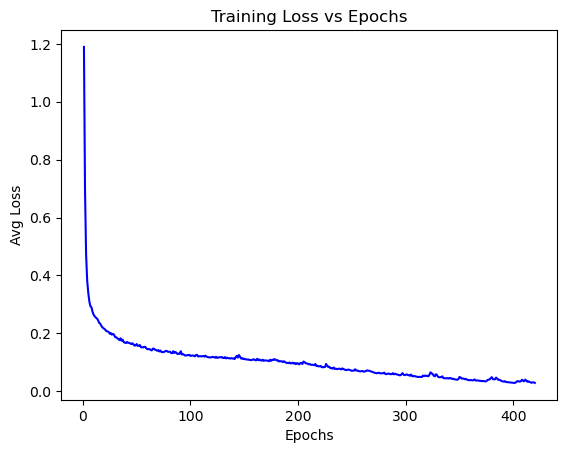

<Figure size 640x480 with 0 Axes>

In [51]:
graph_plot("Training Loss vs Epochs", "Epochs", "Avg Loss", list(loss_dic.keys()), list(loss_dic.values()))

In [52]:
# Saving the model as a .pth file
torch.save(model.state_dict(), model_name)

In [53]:
# Testing the model

# Load the test dataset
test_file = '../../Data/NCBItestset_corpus.txt'
test_lines = read_dataset(test_file)
test_paragraphs = parse_dataset(test_lines)

In [54]:
# Parsing and storing the test dataset
test_sentences = []
test_tags = []

for paragraph in test_paragraphs:
    sentences, annotations = parse_paragraph(paragraph)
    tagged_sentences = tag_annotations(sentences, annotations)
    for sentence, tags in tagged_sentences:
        test_sentences.append(sentence)
        test_tags.append(tags)

In [55]:
# Importing the model file
model = Attention_LSTM_NER_Model(len(word_encoder), len(tag_encoder.classes_)).to(device)
model.load_state_dict(torch.load(model_name))
model.eval()

Attention_LSTM_NER_Model(
  (lstm): LSTM(128, 128, batch_first=True)
  (embedding): Embedding(14805, 128)
  (fc): Linear(in_features=128, out_features=5, bias=True)
  (attention): Attention(
    (attention): Linear(in_features=128, out_features=1, bias=False)
  )
)

In [56]:
# Prepare the test data
test_dataset = LSTM_Attention_NERDataset(test_sentences, test_tags, word_encoder, tag_encoder, '<UNK>')
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=lambda x: x)

# Evaluate the model
all_true_labels = []
all_pred_labels = []

result = "../../Result/TestResults_AttentionLSTM_NER.txt"
with open(result, 'w') as t_file:
    with torch.no_grad():
        for batch in test_dataloader:
            sentences, tags = zip(*batch)
            sentences = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True).to(device)
            tags = torch.nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=-100).to(device)

            outputs = model(sentences)
            outputs = outputs.view(-1, outputs.shape[-1])
            tags = tags.view(-1)

            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            true_labels = tags.cpu().numpy()

            mask = true_labels != -100
            pred_labels = predictions[mask]
            true_labels = true_labels[mask]

            pred_labels_decoded = tag_encoder.inverse_transform(pred_labels)
            true_labels_decoded = tag_encoder.inverse_transform(true_labels)

            for true_label, pred_label in zip(true_labels_decoded, pred_labels_decoded):
                t_file.write(f'True: {true_label}, Pred: {pred_label}\n')
                all_true_labels.append(true_label)
                all_pred_labels.append(pred_label)

# Printing classification report
report = classification_report(all_true_labels, all_pred_labels)
print (report)

                    precision    recall  f1-score   support

I-CompositeMention       0.83      0.06      0.11        89
    I-DiseaseClass       0.19      0.38      0.25       255
        I-Modifier       0.56      0.48      0.52       367
 I-SpecificDisease       0.56      0.60      0.58      1090
                 O       0.97      0.96      0.97     18601

          accuracy                           0.93     20402
         macro avg       0.62      0.50      0.48     20402
      weighted avg       0.93      0.93      0.93     20402

